# SQL Assignment

## PostgreSQL Connection:
AWS Server Details:
* Host: pg-technical-assessment-v2.cvqh5ju3daog.us-east-1.rds.amazonaws.com
* Port: 5432
* Database: postgres
* Username: postgres
* Password: xjcFvv8iy2WRR3H

In [1]:
# !pip install psycopg2-binary

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

conn = psycopg2.connect(
    host="pg-technical-assessment-v2.cvqh5ju3daog.us-east-1.rds.amazonaws.com",
    port=5432,
    dbname="postgres",
    user="postgres",
    password="xjcFvv8iy2WRR3H"
)

In [3]:
def execute_query(query, conn = conn):
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    cur.close()
    return rows

1. **Write a query that would find the total number of customers who have placed at least 3 product orders, where a product order is any that has product_amount_post_refund > 0.**

```sql
with customers_with_three_product_orders as
(SELECT o.customer_id
FROM orders o
INNER JOIN orders_line_items oli 
ON o.source_id = oli.order_id
WHERE o.product_amount_post_refund > 0
GROUP BY o.customer_id
HAVING COUNT(oli.order_id) >= 3)

SELECT COUNT(DISTINCT customer_id) as total_customers
FROM customers_with_three_product_orders;
```

In [4]:
query1 = """
with customers_with_three_product_orders as
(SELECT o.customer_id
FROM orders o
INNER JOIN orders_line_items oli 
ON o.source_id = oli.order_id
WHERE o.product_amount_post_refund > 0
GROUP BY o.customer_id
HAVING COUNT(oli.order_id) >= 3)

SELECT COUNT(DISTINCT customer_id) as total_customers
FROM customers_with_three_product_orders;
"""

In [5]:
rows1 = execute_query(query1)

In [6]:
df1 = pd.DataFrame(rows1, columns = ["total_customers"])
df1

,total_customers
0,2319


---

2. **Write a query that would find, of that group, how many ordered shampoo on their first order. You can assume that any product with the text “Shampoo” in the name, is a shampoo.**

```sql
with customers_with_three_product_orders AS
(SELECT o.customer_id, MIN(oli.created_at) AS first_order_created_at
FROM orders o
INNER JOIN orders_line_items oli 
ON o.source_id = oli.order_id
WHERE o.product_amount_post_refund > 0
GROUP BY o.customer_id
HAVING COUNT(oli.order_id) >= 3),

customers_with_shampoo_as_first_order AS
(SELECT o.customer_id, oli.created_at, oli.product
FROM orders o
INNER JOIN orders_line_items oli 
ON o.source_id = oli.order_id 
WHERE o.customer_id in (SELECT customer_id FROM customers_with_three_product_orders)
AND oli.created_at in (SELECT first_order_created_at FROM customers_with_three_product_orders)
AND oli.product LIKE '%Shampoo%')

SELECT COUNT(DISTINCT customer_id) AS total_customers_ordered_shampoo_on_first_order
FROM customers_with_shampoo_as_first_order
```

In [7]:
query2 = """
with customers_with_three_product_orders AS
(SELECT o.customer_id, MIN(oli.created_at) AS first_order_created_at
FROM orders o
INNER JOIN orders_line_items oli 
ON o.source_id = oli.order_id
WHERE o.product_amount_post_refund > 0
GROUP BY o.customer_id
HAVING COUNT(oli.order_id) >= 3),

customers_with_shampoo_as_first_order AS
(SELECT o.customer_id, oli.created_at, oli.product
FROM orders o
INNER JOIN orders_line_items oli 
ON o.source_id = oli.order_id 
WHERE o.customer_id in (SELECT customer_id FROM customers_with_three_product_orders)
AND oli.created_at in (SELECT first_order_created_at FROM customers_with_three_product_orders)
AND oli.product LIKE '%Shampoo%')

SELECT COUNT(DISTINCT customer_id) AS total_customers_ordered_shampoo_on_first_order
FROM customers_with_shampoo_as_first_order
"""

In [8]:
rows2 = execute_query(query2)

In [9]:
df2 = pd.DataFrame(rows2, columns = ["total_customers_ordered_shampoo_on_first_order"])
df2

,total_customers_ordered_shampoo_on_first_order
0,1895


---

3. **Which products are most correlated with improved retention? (highest likelihood of customer making another purchase)**

To determine which products are most correlated with improved retention, we need to first define a measure of retention. One way to measure retention is to look at the percentage of customers who make at least one repeat purchase within a certain time period after their initial purchase.

```sql
with base as(
SELECT customer_id, created_at, rank() over(partition by customer_id order by created_at) as rk
FROM orders
WHERE product_amount_post_refund > 0),

initial_orders AS (
SELECT customer_id, created_at as initial_order_date
FROM base
WHERE rk=1),

repeat_orders AS (
SELECT customer_id, created_at as repeat_order_date
FROM base
WHERE rk=2)

SELECT oli.product, COUNT(DISTINCT ro.customer_id) AS repeat_purchase, COUNT(DISTINCT io.customer_id) AS initial_purchase,
ROUND((COUNT(DISTINCT ro.customer_id) * 100.00 / COUNT(DISTINCT io.customer_id))::numeric, 2)  AS retention_rate_percentage
FROM orders_line_items oli
JOIN initial_orders io ON oli.customer_id = io.customer_id AND oli.created_at = io.initial_order_date
LEFT JOIN repeat_orders ro ON oli.customer_id = ro.customer_id AND oli.created_at < ro.repeat_order_date
GROUP BY oli.product
ORDER BY retention_rate_percentage desc
```

We can then calculate the correlation between the initial purchase of each product and the likelihood of a repeat purchase.

In [10]:
query3 = """
with base as(
SELECT customer_id, created_at, rank() over(partition by customer_id order by created_at) as rk
FROM orders
WHERE product_amount_post_refund > 0),

initial_orders AS (
SELECT customer_id, created_at as initial_order_date
FROM base
WHERE rk=1),

repeat_orders AS (
SELECT customer_id, created_at as repeat_order_date
FROM base
WHERE rk=2)

SELECT oli.product, COUNT(DISTINCT ro.customer_id) AS repeat_purchase, COUNT(DISTINCT io.customer_id) AS initial_purchase,
ROUND((COUNT(DISTINCT ro.customer_id) * 100.00 / COUNT(DISTINCT io.customer_id))::numeric, 2)  AS retention_rate_percentage
FROM orders_line_items oli
JOIN initial_orders io ON oli.customer_id = io.customer_id AND oli.created_at = io.initial_order_date
LEFT JOIN repeat_orders ro ON oli.customer_id = ro.customer_id AND oli.created_at < ro.repeat_order_date
GROUP BY oli.product
ORDER BY retention_rate_percentage desc
"""

In [11]:
rows3 = execute_query(query3)

In [12]:
df3 = pd.DataFrame(rows3, columns = ["product", "repeat_purchase", "initial_purchase","retention_rate_percentage"])
df3.head(40)

,product,repeat_purchase,initial_purchase,retention_rate_percentage
0,English Breakfast Tea,1,1,100.00
1,Wool Dryer Balls,1,1,100.00
2,Ayate Washcloth,2,2,100.00
3,Tree Free Tissues,1,1,100.00
4,Tree Free Pocket Tissues,1,1,100.00
5,Travel Sunscreen SPF 50,1,1,100.00
6,Travel Moisturizer,1,1,100.00
7,Surface Cleaner,2,2,100.00
8,Lip Balm 0.15oz,5,5,100.00
9,Dental Floss Refills,1,1,100.00


In [13]:
s = df3['retention_rate_percentage'].astype(int)
correlation = np.corrcoef(s, df3['initial_purchase'])
correlation[0, 1]

0.3240588579314626

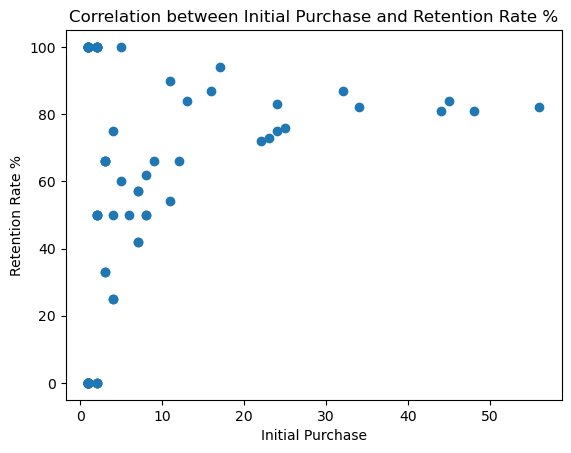

In [14]:
# Plot the scatter plot
plt.scatter(df3['initial_purchase'], s)
plt.xlabel('Initial Purchase')
plt.ylabel('Retention Rate %')
plt.title('Correlation between Initial Purchase and Retention Rate %')
plt.show()

---

4. **Show monthly retention of different monthly acquisition cohorts**

    a. **Assume the first order for each customer is the acquisition cohort (month) of the customer**

	b. **Show how likely users (by cohort) are to buy in their 2nd month, 3rd month etc.**


To calculate the monthly retention of different monthly acquisition cohorts, we can follow the below steps:

* Group the users by their acquisition month (the month of their first purchase).
* For each cohort, calculate the total number of users who made their first purchase in that month.
* For each cohort, calculate the number of users who made a purchase in each subsequent month (2nd, 3rd, 4th, etc.).
* Divide the number of users in each subsequent month by the total number of users in the cohort to calculate the retention rate.
* Visualize the retention rates for each cohort.

```sql
with user_cohorts AS (
  SELECT
    customer_id,
    DATE_TRUNC('month', MIN(created_at)) AS cohort_month
  FROM
    orders
  GROUP BY
    1
),

cohort_sizes AS (
  SELECT
    cohort_month,
    COUNT(DISTINCT customer_id) AS total_users
  FROM
    user_cohorts
  GROUP BY
    1
),

user_retention AS (
  SELECT
    user_cohorts.cohort_month,
    DATE_TRUNC('month', o.created_at) AS order_month,
    COUNT(DISTINCT o.customer_id) AS total_users
  FROM
    orders o
  JOIN
    user_cohorts
  ON
    o.customer_id = user_cohorts.customer_id
  GROUP BY
    1, 2
),

cohort_retention AS (
  SELECT
    user_retention.cohort_month,
    user_retention.order_month,
    ROUND((user_retention.total_users * 100 / cohort_sizes.total_users)::numeric, 2) AS retention_rate_percentage
  FROM
    user_retention
  JOIN
    cohort_sizes
  ON
    user_retention.cohort_month = cohort_sizes.cohort_month
)

SELECT
  cohort_month,
  order_month,
  ROUND(AVG(retention_rate_percentage), 2) AS retention_rate_percentage
FROM
  cohort_retention
GROUP BY
  1, 2
ORDER BY
  1, 2;
```


In [15]:
query4 = """
with user_cohorts AS (
  SELECT
    customer_id,
    DATE_TRUNC('month', MIN(created_at)) AS cohort_month
  FROM
    orders
  GROUP BY
    1
),

cohort_sizes AS (
  SELECT
    cohort_month,
    COUNT(DISTINCT customer_id) AS total_users
  FROM
    user_cohorts
  GROUP BY
    1
),

user_retention AS (
  SELECT
    user_cohorts.cohort_month,
    DATE_TRUNC('month', o.created_at) AS order_month,
    COUNT(DISTINCT o.customer_id) AS total_users
  FROM
    orders o
  JOIN
    user_cohorts
  ON
    o.customer_id = user_cohorts.customer_id
  GROUP BY
    1, 2
),

cohort_retention AS (
  SELECT
    user_retention.cohort_month,
    user_retention.order_month,
    ROUND((user_retention.total_users * 100 / cohort_sizes.total_users)::numeric, 2) AS retention_rate_percentage
  FROM
    user_retention
  JOIN
    cohort_sizes
  ON
    user_retention.cohort_month = cohort_sizes.cohort_month
)

SELECT
  cohort_month,
  order_month,
  ROUND(AVG(retention_rate_percentage), 2) AS retention_rate_percentage
FROM
  cohort_retention
GROUP BY
  1, 2
ORDER BY
  1, 2;
"""

In [16]:
rows4 = execute_query(query4)

In [17]:
df4 = pd.DataFrame(rows4, columns = ["cohort_month", "order_month", "retention_rate_percentage"])
df4.head(15)

,cohort_month,order_month,retention_rate_percentage
0,2017-09-01,2017-09-01,100.00
1,2017-09-01,2017-10-01,16.00
2,2017-09-01,2017-11-01,24.00
3,2017-09-01,2017-12-01,26.00
4,2017-09-01,2018-01-01,26.00
5,2017-09-01,2018-02-01,20.00
6,2017-09-01,2018-03-01,21.00
7,2017-09-01,2018-04-01,21.00
8,2017-09-01,2018-05-01,26.00
9,2017-09-01,2018-06-01,21.00


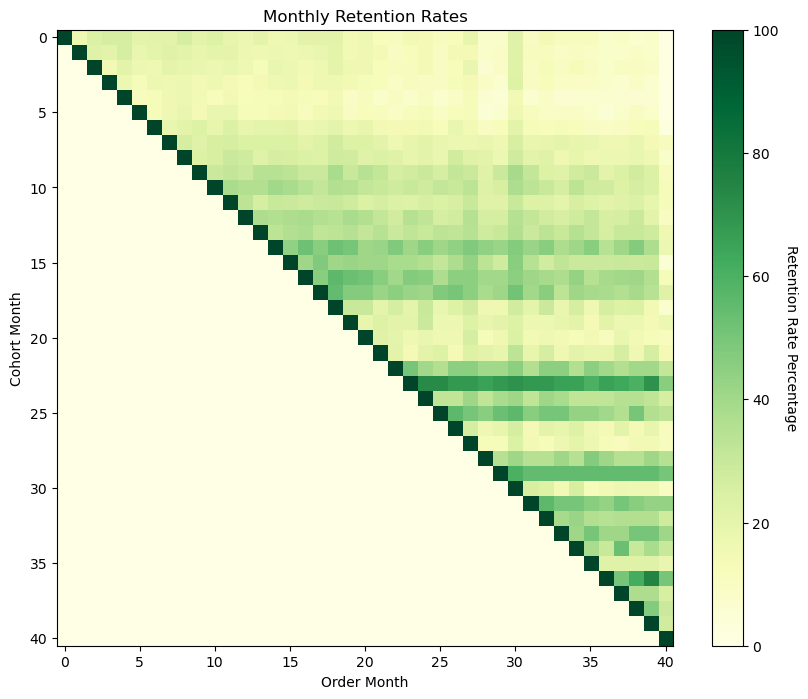

In [19]:
# pivot the dataframe to create a heatmap (for visualization purpose)
df4["retention_rate_percentage"] = pd.to_numeric(df4["retention_rate_percentage"])

heatmap_df = df4.pivot(index="cohort_month", columns="order_month", values="retention_rate_percentage")
heatmap_df = heatmap_df.fillna(0)
# create the heatmap using Matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Monthly Retention Rates")
ax.set_xlabel("Order Month")
ax.set_ylabel("Cohort Month")
im = ax.imshow(heatmap_df, cmap="YlGn")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Retention Rate Percentage", rotation=-90, va="bottom")

plt.show()

The data has 41 unique months. Here, numbers 0 to 40 represents the months. 

5. **In your own words (no data-pull necessary), how would you figure out how to price each of our products, in order to maximize company profits?**


To figure out how to price each of our products to maximize company profits, we can use a combination of approaches such as **cost-plus pricing**, **value-based pricing**, and **competitive pricing**.

* **Cost-plus pricing**: We can start by calculating the cost of each product, which includes the cost of raw materials, manufacturing, packaging, shipping, and any other costs involved in the production process. We can then add a profit margin to the cost to arrive at the selling price. This approach ensures that we cover all costs and make a profit, but it does not take into account the value of the product to the customer.
```
Selling price = Cost + (Cost * Profit margin)
Where,
Cost = Cost of raw materials + Manufacturing cost + Packaging cost + Shipping cost + Other costs
Profit margin = (Desired profit / Cost) * 100
```

* **Value-based pricing**: This approach involves setting a price based on the perceived value of the product to the customer. We can conduct market research to determine how much customers are willing to pay for each product based on their perceived value. For example, if a product offers unique features or solves a problem that no other product on the market does, we can charge a higher price.
```
Selling price = Perceived value to the customer
Where,
Perceived value = Customer's willingness to pay + Competitive prices + Unique features or benefits
```

* **Competitive pricing**: We can also look at the prices of similar products offered by our competitors and price our products accordingly. This approach is useful when we have limited information about the customer's perceived value of our product. We can set our prices higher or lower than our competitors depending on the unique value proposition of our product.

```
Selling price = Competitor's price + (Competitor's price * Markup percentage)
Where,
Markup percentage = (Desired profit / Cost) * 100
```

Once we have determined the optimal pricing strategy, we can use data analysis to monitor its effectiveness and make adjustments as necessary. We can use techniques such as **A/B testing** to test different prices and measure their impact on sales and profits. Additionally, we can use statistical techniques like **Regression analysis** and **Customer segmentation** to **track customer behavior and purchasing patterns**, and use this information to adjust prices based on the **customer's willingness to pay**,  the **product's perceived value** and create targeted pricing strategies for each segment.

In [20]:
conn.close()